#Work Flow

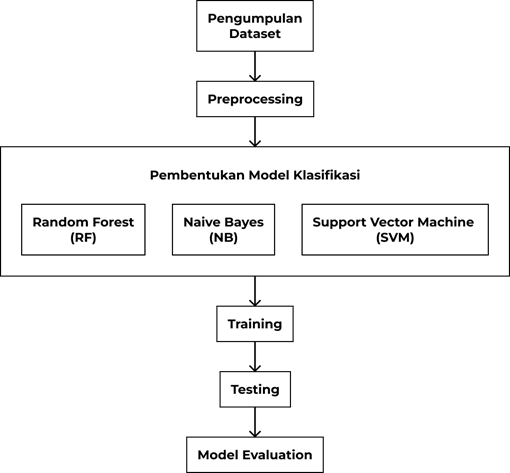

#Import Libraries

In [ ]:
#Libraries for general purpose
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
import numpy as np
import re
import string
import time

# Support Vector Machine (SVM)
from sklearn.svm import SVC
# Naive Bayes (NB)
from sklearn.naive_bayes import MultinomialNB
# Random Forest (RF)
from sklearn.ensemble import RandomForestClassifier

# Model Create
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Preprocessing Word
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

# To save and read model
import pickle

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Import Dataset

In [ ]:
# Clone dataset dari github
!git clone https://github.com/Theofilusarifin/cyberbullying_resources.git

Cloning into 'cyberbullying_resources'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 2), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [ ]:
df = pd.read_csv('cyberbullying_resources/cyberbullying_tweets.csv')

#Functions

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

#Exploratory Data Analysis

In [ ]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

As we can see data is distributted equally

In [ ]:
# length of dataset
len(df)

47692

#Preprocessing

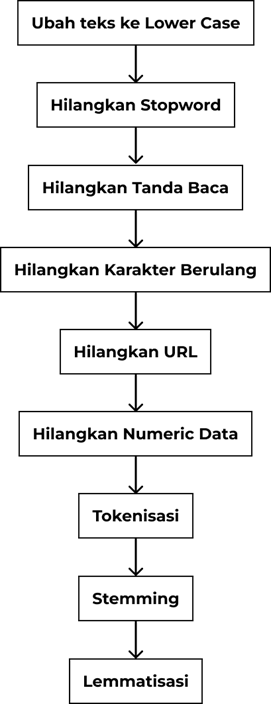

In [ ]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

There is no null value in data so dropNa is no needed

In [ ]:
# storing the data in lists
tweet, type = list(df['tweet_text']), list(df['cyberbullying_type'])

In [ ]:
# Get each sentiment
sentiments = list(set(type))
sentiments

['religion',
 'gender',
 'ethnicity',
 'not_cyberbullying',
 'age',
 'other_cyberbullying']

In [ ]:
# Encoding the labels
labelencoder = LabelEncoder()
df['cyberbullying_type_encoded'] = labelencoder.fit_transform(df['cyberbullying_type'])

In [ ]:
df[['cyberbullying_type', 'cyberbullying_type_encoded']].value_counts()

cyberbullying_type   cyberbullying_type_encoded
religion             5                             7998
age                  0                             7992
gender               2                             7973
ethnicity            1                             7961
not_cyberbullying    3                             7945
other_cyberbullying  4                             7823
dtype: int64

In [ ]:
# converting tweet text to lower case
df['tweet_text'] = df['tweet_text'].str.lower()
df.tail()

,tweet_text,cyberbullying_type,cyberbullying_type_encoded
47687,"black ppl aren't expected to do anything, depe...",ethnicity,1
47688,turner did not withhold his disappointment. tu...,ethnicity,1
47689,i swear to god. this dumb nigger bitch. i have...,ethnicity,1
47690,yea fuck you rt @therealexel: if youre a nigge...,ethnicity,1
47691,bro. u gotta chill rt @chillshrammy: dog fuck ...,ethnicity,1


In [ ]:
# stopwords list that needs to be excluded from the data
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
# removing stopwords from the tweet text
STOPWORDS = set(stopwordlist)

def clean_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df['tweet_text'] = df['tweet_text'].apply(lambda text: clean_stopwords(text))

In [ ]:
# cleaning and removing punctuations
english_puctuations = string.punctuation

def clean_puctuations(text):
    translator = str.maketrans('','', english_puctuations)
    return text.translate(translator)

df['tweet_text'] = df['tweet_text'].apply(lambda x : clean_puctuations(x))

In [ ]:
# cleaning and removing repeating characters
def clean_repeating_characters(text):
    return re.sub(r'(.)1+', r'1', text)

df['tweet_text'] = df['tweet_text'].apply(lambda x: clean_repeating_characters(x))

In [ ]:
# cleaning and removing URLs
def clean_URLs(text):
    return re.sub(r"((www.[^s]+)|(http\S+))","",text)

df['tweet_text'] = df['tweet_text'].apply(lambda x : clean_URLs(x))

In [ ]:
# cleaning and removing numeric data
def clean_numeric(text):
    return re.sub('[0-9]+', '', text)
    
df['tweet_text'] = df['tweet_text'].apply(lambda x: clean_numeric(x))

In [ ]:
# Tokenization of tweet text
tokenizer = RegexpTokenizer('\w+')
df['tweet_text'] = df['tweet_text'].apply(tokenizer.tokenize)

In [ ]:
# stemming
st = nltk.PorterStemmer()

def text_stemming(text):
    text = [st.stem(word) for word in text]
    return text

df['tweet_text'] = df['tweet_text'].apply(lambda x: text_stemming(x))

In [ ]:
# lemmatization
lm = nltk.WordNetLemmatizer()

def text_lemmatization(text):
    text = [lm.lemmatize(word) for word in text]
    return text

df['tweet_text'] = df['tweet_text'].apply(lambda x: text_lemmatization(x))

In [ ]:
df[['cyberbullying_type', 'cyberbullying_type_encoded']].value_counts()

cyberbullying_type   cyberbullying_type_encoded
religion             5                             7998
age                  0                             7992
gender               2                             7973
ethnicity            1                             7961
not_cyberbullying    3                             7945
other_cyberbullying  4                             7823
dtype: int64

#Word Cloud

In [ ]:
# plotting word cloud excluding other_cybberbullying and not_cyberbullying
new_df = df
new_df = new_df[new_df['cyberbullying_type'] != 'other_cyberbullying']
new_df = new_df[new_df['cyberbullying_type'] != 'not_cyberbullying']
new_df = new_df['tweet_text'].apply(lambda x: " ".join(x))

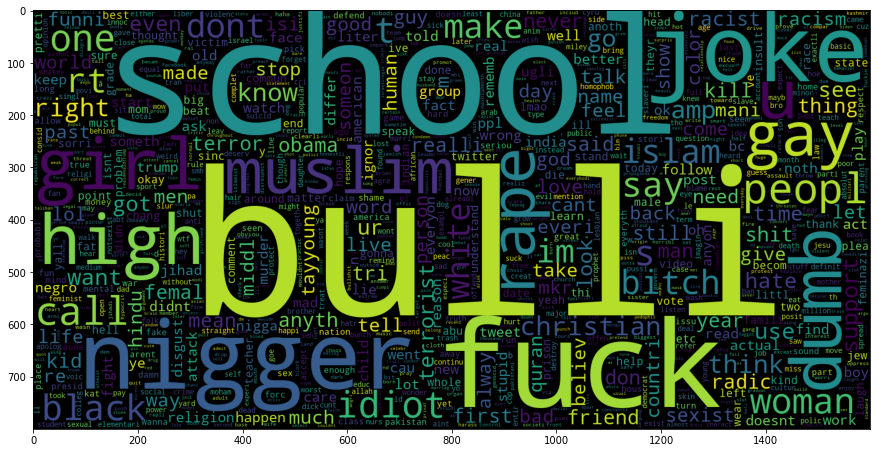

In [ ]:
plt.figure(figsize= (15,15))
wc = WordCloud(max_words=1000, width= 1600, height= 800, 
                collocations= False).generate(' '.join(new_df))
plt.imshow(wc)

In [ ]:
# Creating a word cloud
# exclude the tweets which are not_cyberbullying 
data = pd.read_csv('cyberbullying_resources/cyberbullying_tweets.csv')
data = data[data['cyberbullying_type'] != "not_cyberbullying"]
data['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

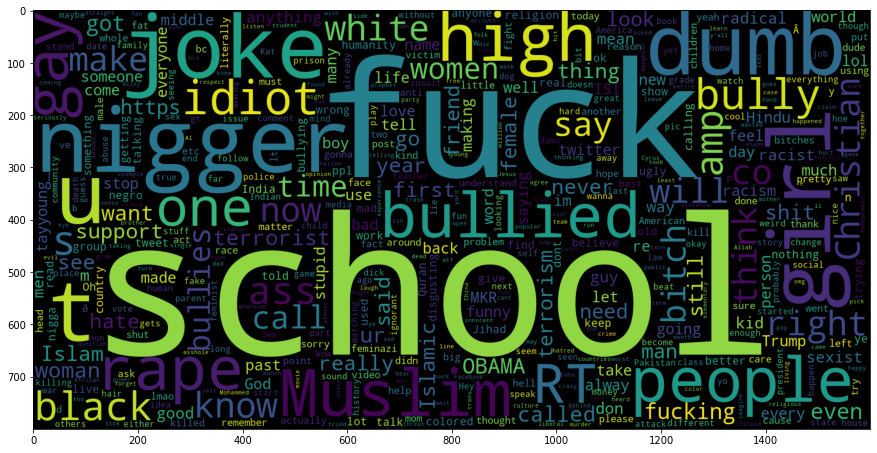

In [ ]:
# word cloud

plotting_data = data['tweet_text']
plt.figure(figsize= (15,15))
wc = WordCloud(max_words=500, width= 1600, height= 800, 
                collocations= False).generate(' '.join(plotting_data))
plt.imshow(wc)

#Split Data

In [ ]:
df['tweet_text'] = df['tweet_text'].apply(lambda x : " ".join(x))

In [ ]:
# Splitting the data into train and test
X, y = df['tweet_text'], df['cyberbullying_type_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 41)

In [ ]:
# Transforming the data using TF-IDF Vectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features= 500000)
vectoriser.fit(X_train)
print("No. of feature words: ",len(vectoriser.get_feature_names()))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature words:  312805


In [ ]:
# transforming the data
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

#Model

##Naive Bayes (NB)

In [ ]:
t1 = time.perf_counter()

# NB Classifier
nb_clf = MultinomialNB().fit(X_train, y_train)

# time
t2 = time.perf_counter()
print('time taken to run:',t2-t1)

time taken to run: 0.13804425200001447


In [ ]:
y_nb_pred  = nb_clf.predict(X_test)

##Random Forest

In [ ]:
t1 = time.perf_counter()

# RF Classifier
rf_clf = RandomForestClassifier().fit(X_train, y_train)

# time
t2 = time.perf_counter()
print('time taken to run:',t2-t1)

time taken to run: 2669.797152942


In [ ]:
y_rf_pred  = rf_clf.predict(X_test)

##Support Vector Machine (SVM)

In [ ]:
t1 = time.perf_counter()

# SVM Classifier
svm_clf = SVC(kernel= 'linear', C = 1).fit(X_train, y_train)

# time
t2 = time.perf_counter()
print('time taken to run:',t2-t1)

time taken to run: 292.671478751


In [39]:
y_svm_pred  = svm_clf.predict(X_test)

# Model Evaluation

## Confussion Matrix

### Naive Bayes

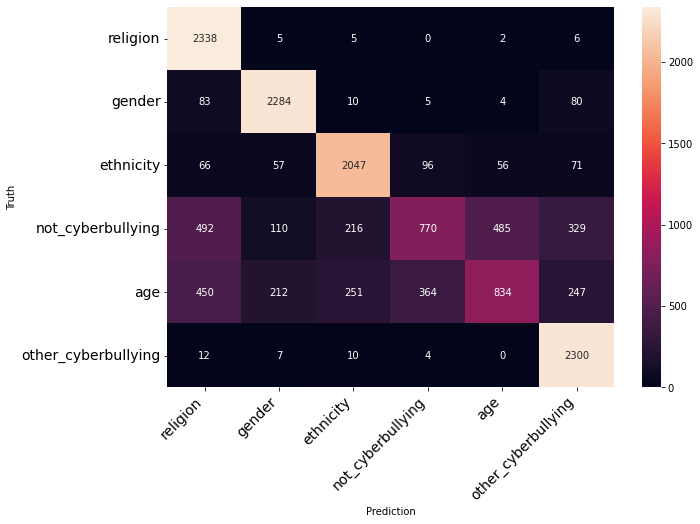

In [40]:
# Confussion Matrix Naive Bayes
cm = confusion_matrix(y_test,y_nb_pred)
print_confusion_matrix(cm,sentiments)

### Random Forest

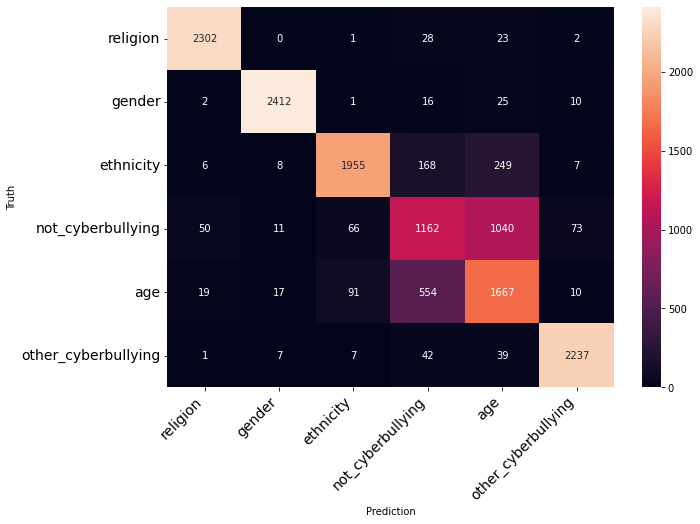

In [41]:
# Confussion Matrix Random Forest
cm = confusion_matrix(y_test,y_rf_pred)
print_confusion_matrix(cm,sentiments)

### SVM

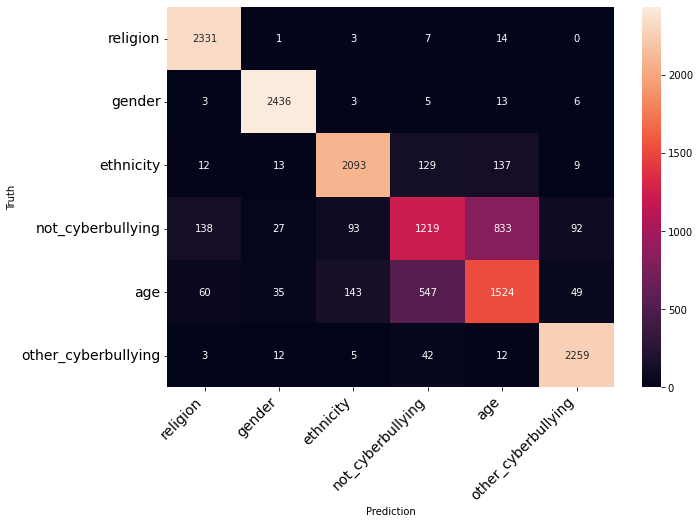

In [42]:
# Confussion Matrix SVM
cm = confusion_matrix(y_test,y_svm_pred)
print_confusion_matrix(cm,sentiments)

## Classification Report

In [43]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, y_nb_pred, target_names=sentiments))

Classification Report for Naive Bayes:
                      precision    recall  f1-score   support

           religion       0.68      0.99      0.81      2356
             gender       0.85      0.93      0.89      2466
          ethnicity       0.81      0.86      0.83      2393
  not_cyberbullying       0.62      0.32      0.42      2402
                age       0.60      0.35      0.45      2358
other_cyberbullying       0.76      0.99      0.86      2333

           accuracy                           0.74     14308
          macro avg       0.72      0.74      0.71     14308
       weighted avg       0.72      0.74      0.71     14308



In [44]:
print('Classification Report for Random Forest:\n',classification_report(y_test, y_rf_pred, target_names=sentiments))

Classification Report for Random Forest:
                      precision    recall  f1-score   support

           religion       0.97      0.98      0.97      2356
             gender       0.98      0.98      0.98      2466
          ethnicity       0.92      0.82      0.87      2393
  not_cyberbullying       0.59      0.48      0.53      2402
                age       0.55      0.71      0.62      2358
other_cyberbullying       0.96      0.96      0.96      2333

           accuracy                           0.82     14308
          macro avg       0.83      0.82      0.82     14308
       weighted avg       0.83      0.82      0.82     14308



In [45]:
print('Classification Report for Support Vector Machine:\n',classification_report(y_test, y_svm_pred, target_names=sentiments))

Classification Report for Support Vector Machine:
                      precision    recall  f1-score   support

           religion       0.92      0.99      0.95      2356
             gender       0.97      0.99      0.98      2466
          ethnicity       0.89      0.87      0.88      2393
  not_cyberbullying       0.63      0.51      0.56      2402
                age       0.60      0.65      0.62      2358
other_cyberbullying       0.94      0.97      0.95      2333

           accuracy                           0.83     14308
          macro avg       0.82      0.83      0.82     14308
       weighted avg       0.82      0.83      0.82     14308



## Sklearn Metrics Accuracy 

In [46]:
print("Accuracy Score (Naive Bayes): ", accuracy_score(y_test, y_nb_pred))
print("Accuracy Score (Random Forest): ", accuracy_score(y_test, y_rf_pred))
print("Accuracy Score (Support Vector Machine): ", accuracy_score(y_test, y_svm_pred))

Accuracy Score (Naive Bayes):  0.7389572267263069
Accuracy Score (Random Forest):  0.8201705339670115
Accuracy Score (Support Vector Machine):  0.8290466871680179


#Save Model

In [ ]:
# dumping the model
pickle.dump(nb_clf, open('nb_model.bin', 'wb'))
pickle.dump(rf_clf, open('rf_model.bin', 'wb'))
pickle.dump(svm_clf, open('svm_model.bin', 'wb'))

# Load Model

In [ ]:
# Upload model first then execute this code
nb_clf = pickle.load(open("nb_model.bin", "rb"))
rf_clf = pickle.load(open("rf_model.bin", "rb"))
svm_clf = pickle.load(open("svm_model.bin", "rb"))

#Predicting Output

In [74]:
interpretations = {
        0 : "Age",
        1 : "Ethnicity",
        2 : "Gender",
        3 : "Not Cyberbullying",
        4 : "Other Cyberbullying",
        5 : "Religion"
    }
    
def result(prediction):
  for i in interpretations.keys():
        if i == prediction:
            return interpretations[i]

In [75]:
example = np.zeros(100)
example = ["Muslim is bad and christian is bad too",]
example = vectoriser.transform(example)
example

<1x312805 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [76]:
print(result(nb_clf.predict(example)))

Religion


In [77]:
print(result(rf_clf.predict(example)))

Religion


In [78]:
print(result(svm_clf.predict(example)))

Religion
